In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

In [67]:
df = pd.read_csv("Reviews.csv")

print(df.shape)
df = df.head(500)

print(df.shape)
df.head()

(568454, 10)
(500, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


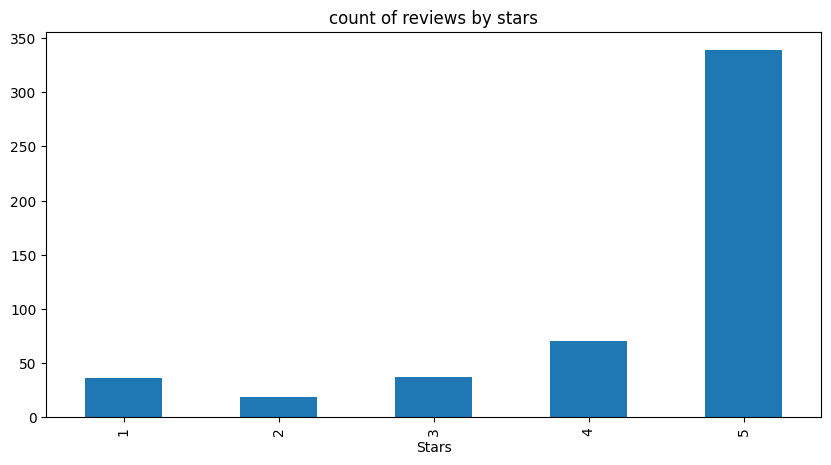

In [68]:
ax = df["Score"].value_counts().sort_index().plot(kind = 'bar',
                                                 title = 'count of reviews by stars',
                                                 figsize = (10,5))
ax.set_xlabel('Stars')
plt.show()


# Basic NLTK 

In [69]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [70]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [71]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

# Step 1. VADER Seniment Scoring

In [72]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [73]:
example = "This pretty bad"
sia.polarity_scores(example)

{'neg': 0.455, 'neu': 0.13, 'pos': 0.416, 'compound': -0.0772}

In [74]:
res = {}
total = len(df)
for i, row in df.iterrows():
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


In [75]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [76]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


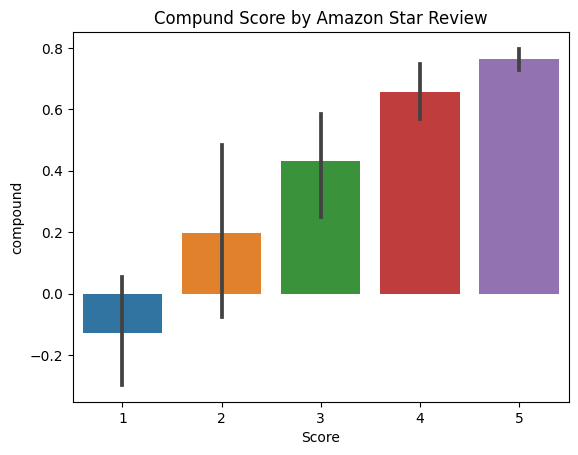

In [77]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

# Roberta Model 

In [78]:
import transformers

In [79]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [80]:
roberta = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(roberta)
model = AutoModelForSequenceClassification.from_pretrained(roberta)

# Vader results 

In [81]:
print(example)
sia.polarity_scores(example)

This pretty bad


{'neg': 0.455, 'neu': 0.13, 'pos': 0.416, 'compound': -0.0772}

# Roberta 

In [82]:
encoded_text = tokenizer (example, return_tensors= 'pt')
output = model (**encoded_text)
scores = output[0][0] .detach () . numpy ()
scores = softmax (scores)
scores_dict = {
    'Negative' : scores[0],
    'Neutral' : scores[1],
    'Positive' : scores[2]
}
print(example)
scores_dict 

This pretty bad


{'Negative': 0.94454616, 'Neutral': 0.04918477, 'Positive': 0.0062690396}

In [89]:
def polarity_scores_roberta(example) :
    encoded_text = tokenizer (example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output [0] [0] .detach () .numpy ()
    scores = softmax (scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores [2]
    }
    return(scores_dict)

In [96]:
res = {}
for i, row in tqdm(df.iterrows(), total=len (df) ) :
    try:
        text = row[ 'Text' ]
        myid = row[ 'Id']
        vader_result = sia.polarity_scores (text)
        vader_result_rename = {}
        for key, value in vader_result.items () :
            vader_result_rename [f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res [myid] = both
        
    except RuntimeError:
     print (f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [102]:
results = pd.DataFrame(res).T
results = results.reset_index().rename(columns={'index': 'Id'})
results = results.merge(df, how='left')
results.drop(["vader_compound"], axis = 1, inplace = True)

In [113]:
results.head()

,Id,vader_neg,vader_neu,vader_pos,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.009624,0.049980,0.940396,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [114]:
results.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg',
       'roberta_neu', 'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

/Users/dhanushvasarla/miniconda3/envs/sentiment_analysis/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


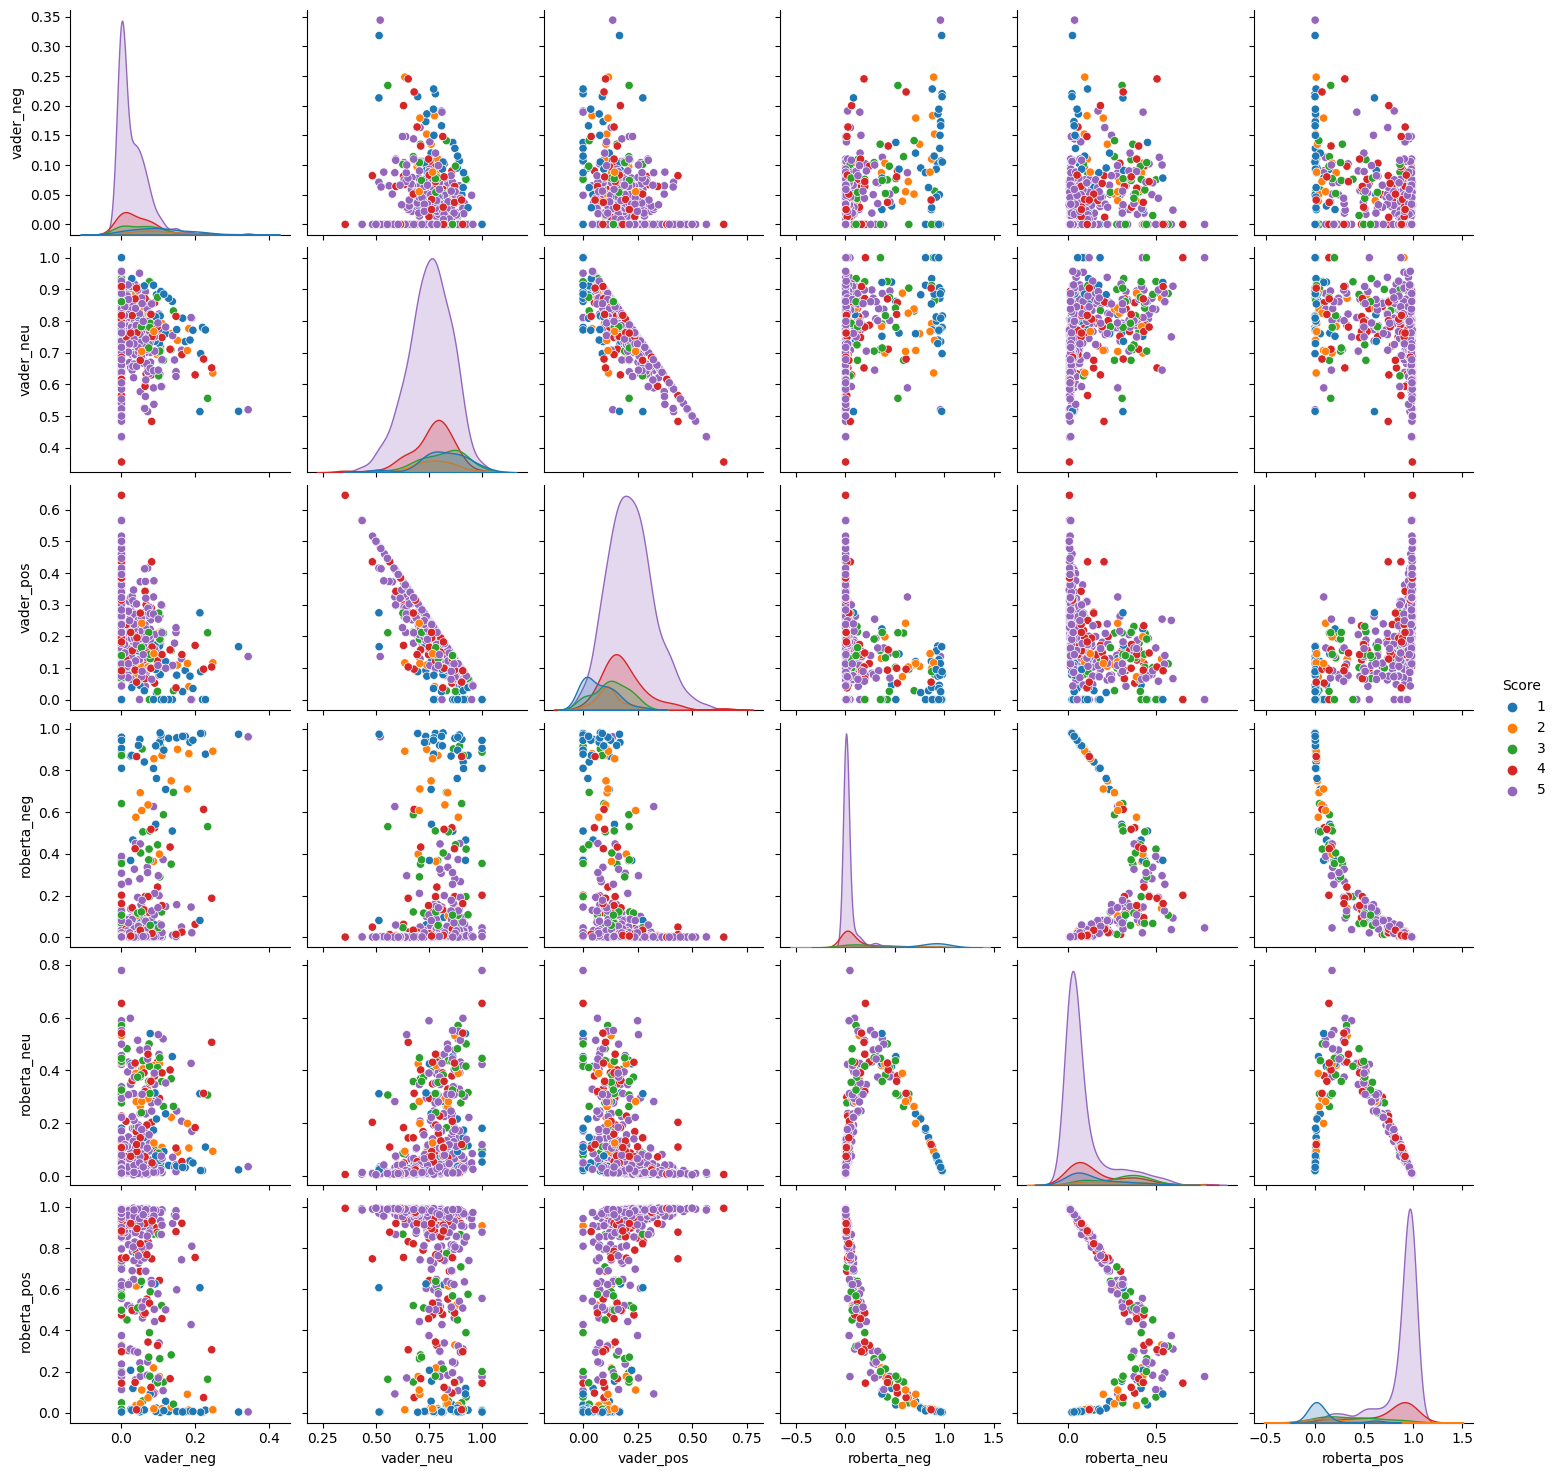

In [122]:
sns.pairplot(data = results , vars  = ['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg',
       'roberta_neu', 'roberta_pos'],
            hue = 'Score',
            palette = 'tab1   0')

plt.show()

In [129]:
from transformers import pipeline

sent_analysis = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [131]:
sent_analysis('I hate it')

[{'label': 'NEGATIVE', 'score': 0.9996398687362671}]